# 02_Feature_Engineering — Sequence & Basic Biophysics Features

This notebook uses `src/feature_engineering.py` to compute Δ features and BLOSUM62
for single-mutation ΔΔG data, then inspects distributions and correlations.

## Imports & Paths

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# project root resolution
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

print("Project root:", PROJECT_ROOT)

Project root: /Users/saturnine/protein-multimutant


## Run feature engineering (calls the module)

In [2]:
# Make sure src is on the path if needed
import sys
sys.path.append(str(PROJECT_ROOT))

from src.feature_engineering import build_features

inp = DATA_PROCESSED / "single_mut_clean.csv"
out = DATA_PROCESSED / "features_basic.csv"

features = build_features(inp=inp, out=out)
features.head()

[OK] Features saved → /Users/saturnine/protein-multimutant/data/processed/features_basic.csv  (n=2645, d=19)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,delta_hydropathy,delta_charge,delta_volume,delta_polarity,blosum62,is_gly,is_pro,is_to_gly,is_to_pro
0,1A43A,1A43,A,C,218.0,S,-3.70,7.3,25.0,218,-3.3,0.0,-19.5,3.7,-1.0,0,0,0,0
1,1A43A,1A43,A,E,159.0,D,-4.55,7.3,25.0,159,0.0,0.0,-27.3,0.7,2.0,0,0,0,0
2,1A43A,1A43,A,G,156.0,A,-2.40,7.3,25.0,156,2.2,0.0,28.5,-0.9,0.0,1,0,0,0
3,1A43A,1A43,A,R,167.0,A,-4.55,7.3,25.0,167,6.3,-1.0,-84.8,-2.4,-1.0,0,0,0,0
4,1A43A,1A43,A,W,184.0,A,-0.70,7.3,25.0,184,2.7,0.0,-139.2,2.7,-3.0,0,0,0,0


## Basic Checks

In [3]:
print(features.shape)
features.sample(5)

(2645, 19)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,delta_hydropathy,delta_charge,delta_volume,delta_polarity,blosum62,is_gly,is_pro,is_to_gly,is_to_pro
1488,1AARA,1OTR,B,I,36.0,F,-0.86,3.0,50.0,36,-1.7,0.0,23.2,0.0,0.0,0,0,0,0
2583,1RX4A,5DFR,A,N,59.0,V,0.36,7.8,15.0,59,7.7,0.0,25.9,-5.7,-3.0,0,0,0,0
1565,1C5GA,1QLP,A,Y,160.0,A,-0.21,7.8,25.0,160,3.1,0.0,-105.0,1.9,-2.0,0,0,0,0
1072,1FLVA,1FTG,A,S,71.0,A,-0.44,7.0,34.6,71,2.6,0.0,-0.4,-1.1,1.0,0,0,0,0
543,1EY0A,1EY0,A,D,77.0,G,-1.81,7.0,20.0,77,3.1,1.0,-51.0,-4.0,-1.0,0,0,1,0


## Distributions of Δ features

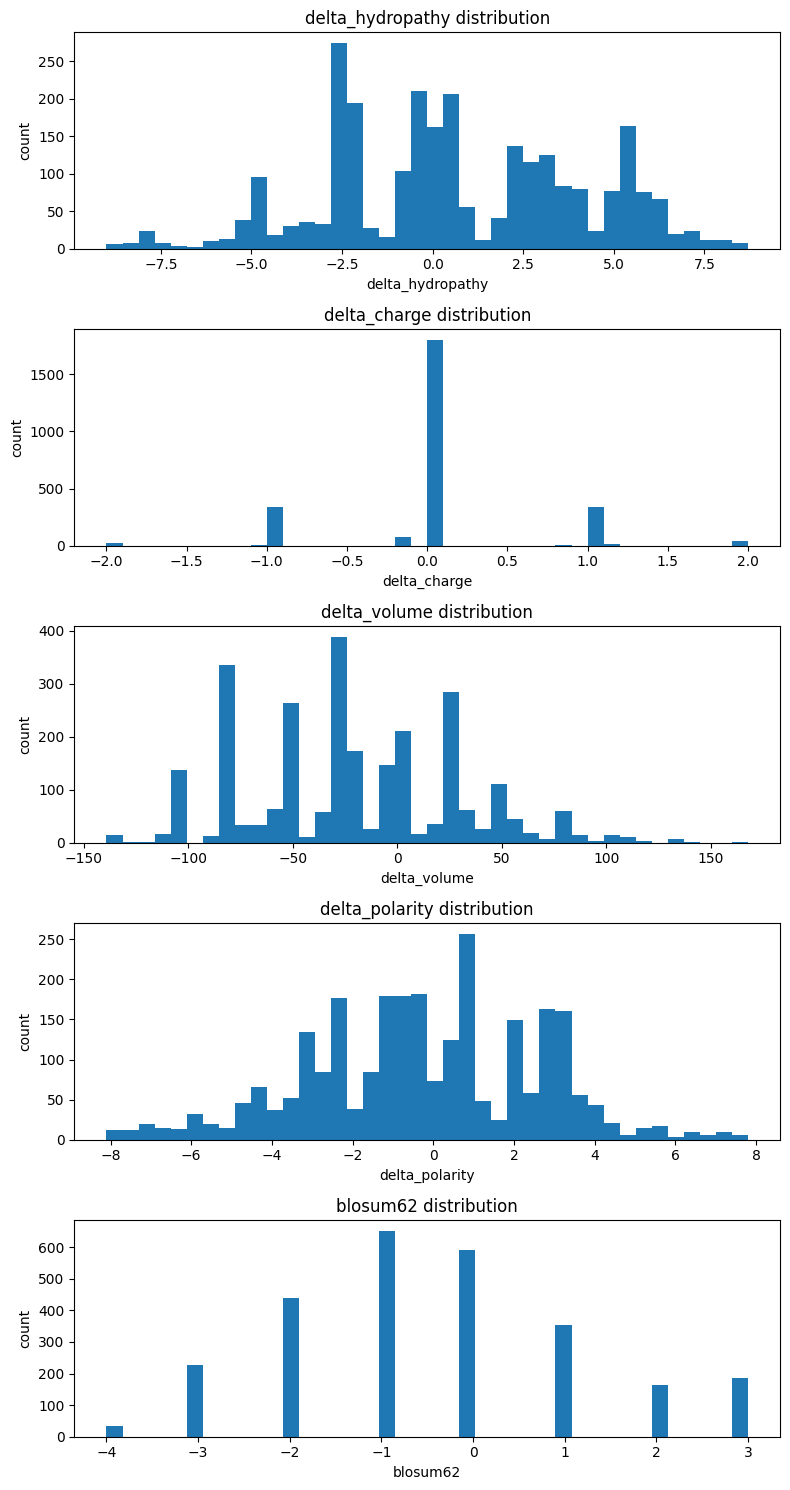

In [4]:
num_cols = ["delta_hydropathy","delta_charge","delta_volume","delta_polarity","blosum62"]
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, 3*len(num_cols)))
for ax, c in zip(axes, num_cols):
    ax.hist(features[c].dropna(), bins=40)
    ax.set_title(f"{c} distribution")
    ax.set_xlabel(c); ax.set_ylabel("count")
fig.tight_layout()
plt.show()

## Correlation with experimental ΔΔG

In [5]:
corr = features[["ddg_exp_kcal"] + num_cols].corr().round(3)
corr

,ddg_exp_kcal,delta_hydropathy,delta_charge,delta_volume,delta_polarity,blosum62
ddg_exp_kcal,1.000,0.283,0.050,0.289,-0.366,0.113
delta_hydropathy,0.283,1.000,-0.037,0.020,-0.855,-0.071
delta_charge,0.050,-0.037,1.000,0.262,-0.193,-0.002
delta_volume,0.289,0.020,0.262,1.000,-0.319,0.192
delta_polarity,-0.366,-0.855,-0.193,-0.319,1.000,0.075
blosum62,0.113,-0.071,-0.002,0.192,0.075,1.000


## Quick correlation heatmap

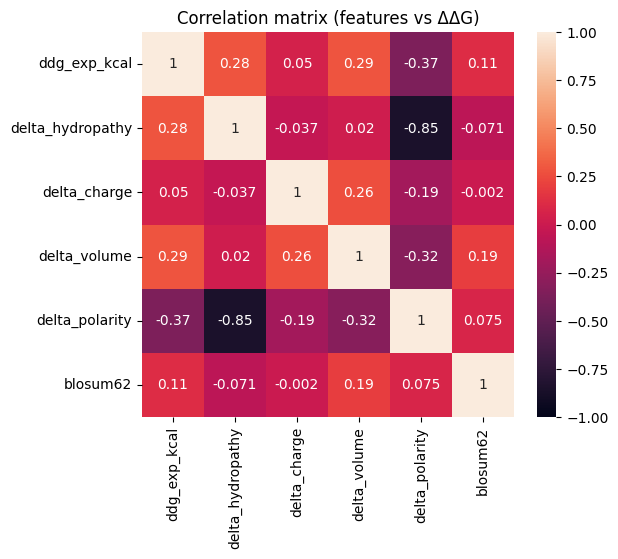

In [6]:
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)
plt.title("Correlation matrix (features vs ΔΔG)")
plt.show()

## Single-protein view (1EY0A)

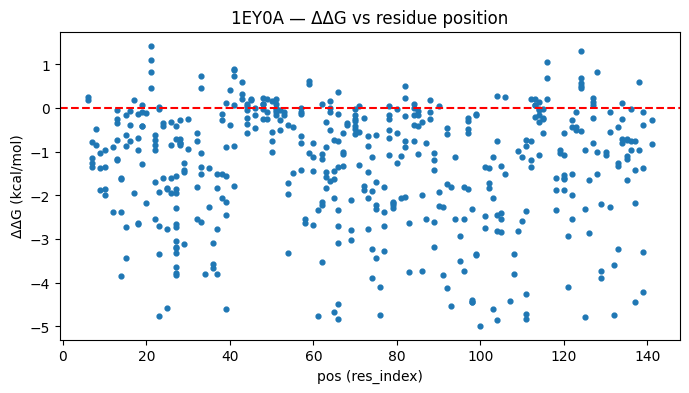

In [7]:
if "clid" in features.columns and (features["clid"]=="1EY0A").any():
    sub = features[features["clid"]=="1EY0A"]
    plt.figure(figsize=(8,4))
    plt.scatter(sub["pos"], sub["ddg_exp_kcal"], s=12)
    plt.axhline(0, ls="--", c="r")
    plt.title("1EY0A — ΔΔG vs residue position")
    plt.xlabel("pos (res_index)"); plt.ylabel("ΔΔG (kcal/mol)")
    plt.show()

## Files produced
- `data/processed/features_basic.csv`
- Ready for `03_ML_Model.ipynb` (training RF/GB/XGB with these features).